In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, Normalizer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


(a) Data Preprocessing

In this section, we preprocess the dataset by performing essential steps in the data mining process. These include:

Exploratory Data Analysis: We generate Q-Q plots and histograms to check feature distributions and apply transformations when necessary.

Feature Encoding: Categorical variables are encoded using One-Hot Encoding for nominal data and Ordinal Encoding for ordered data.

Feature Scaling: We scale and standardize numerical features using techniques like StandardScaler to ensure equal contribution of each feature to the model.

Feature Discretization: Continuous features may be discretized into bins to improve model performance for certain algorithms.

Handling Class Imbalance: If class imbalance is detected, we apply SMOTE to balance the dataset and improve model accuracy.

In [61]:
employee_data = pd.read_csv('Employee.csv')
print("shape of the data: ", employee_data.shape)
employee_data.head()

shape of the data:  (4653, 9)


,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


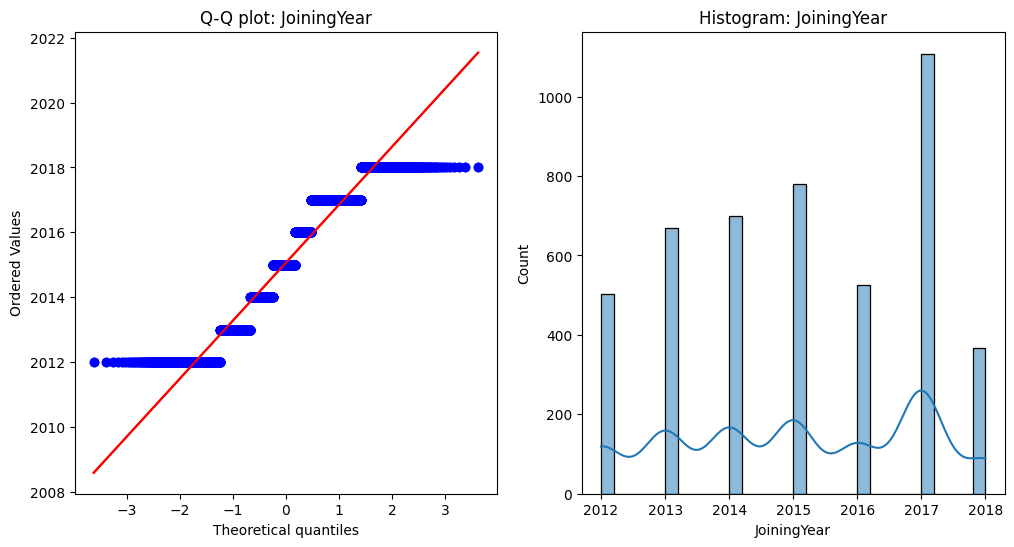

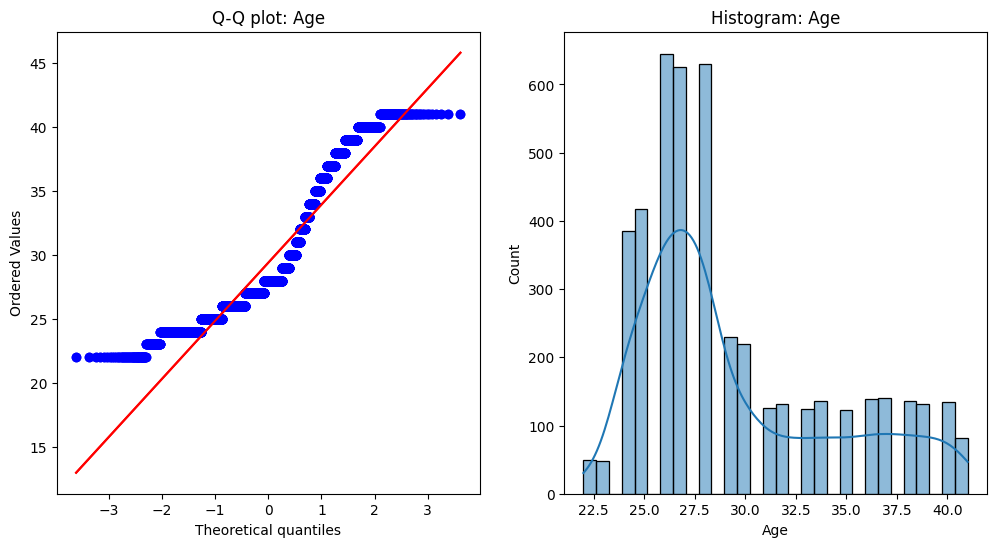

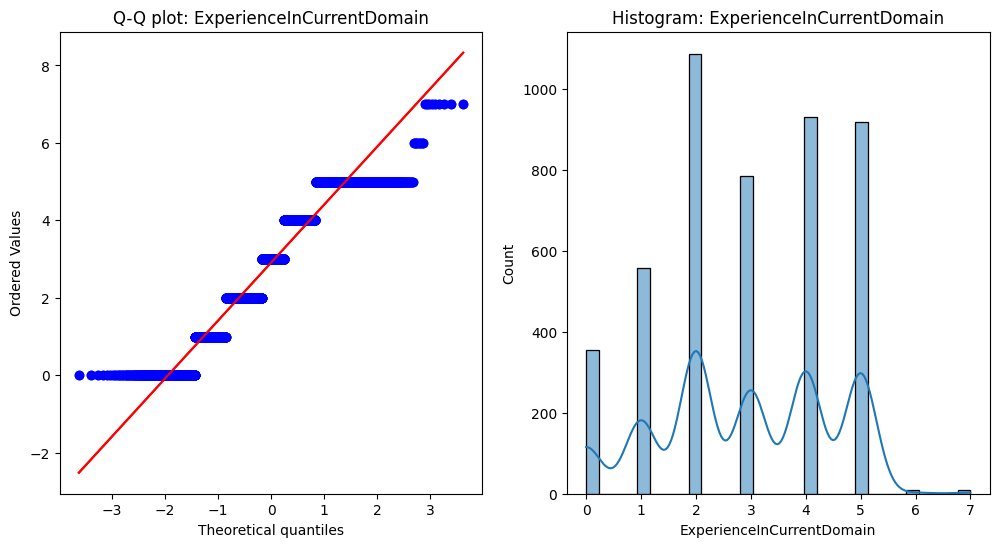

In [62]:
def plot_qq_hist(data, feature, title=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    stats.probplot(data[feature], dist="norm", plot=plt)
    stats.probplot(data[feature], plot=plt)

    if title != "":
        plt.title(title)
    else:
        plt.title(f"Q-Q plot: {feature}")

    plt.subplot(1, 2, 2)
    sns.histplot(data[feature], kde=True, bins=30)
    if title != "":
        plt.title(title)
    else:
        plt.title(f"Histogram: {feature}")

    plt.show()

for feature in ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']:
    plot_qq_hist(employee_data, feature)

In [63]:
X = employee_data.drop(columns=['LeaveOrNot'])
y = employee_data['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("shape of the training data: ", X_train.shape)
print("shape of the testing data: ", X_test.shape)

print("shape of the training target: ", y_train.shape)
print("shape of the testing target: ", y_test.shape)

shape of the training data:  (3722, 8)
shape of the testing data:  (931, 8)
shape of the training target:  (3722,)
shape of the testing target:  (931,)


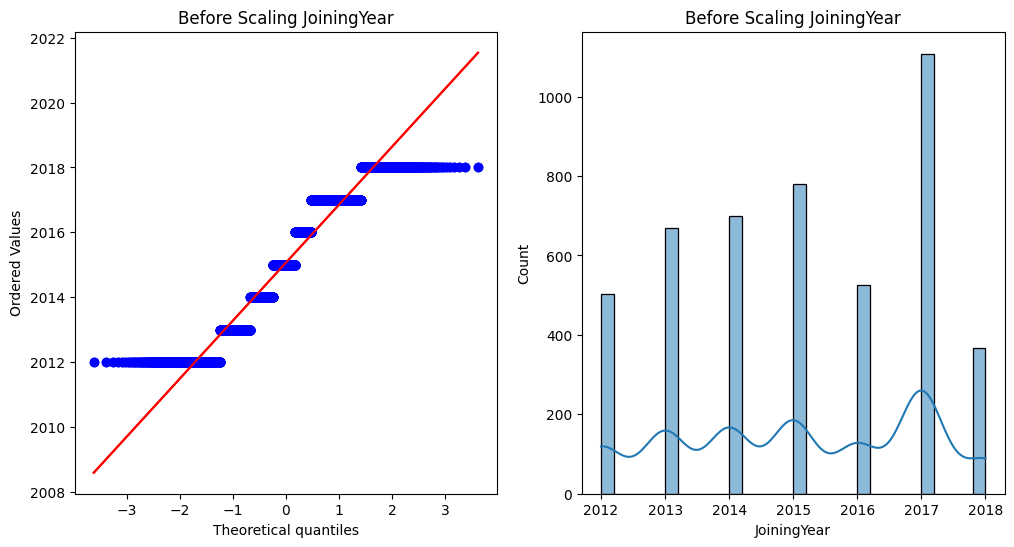

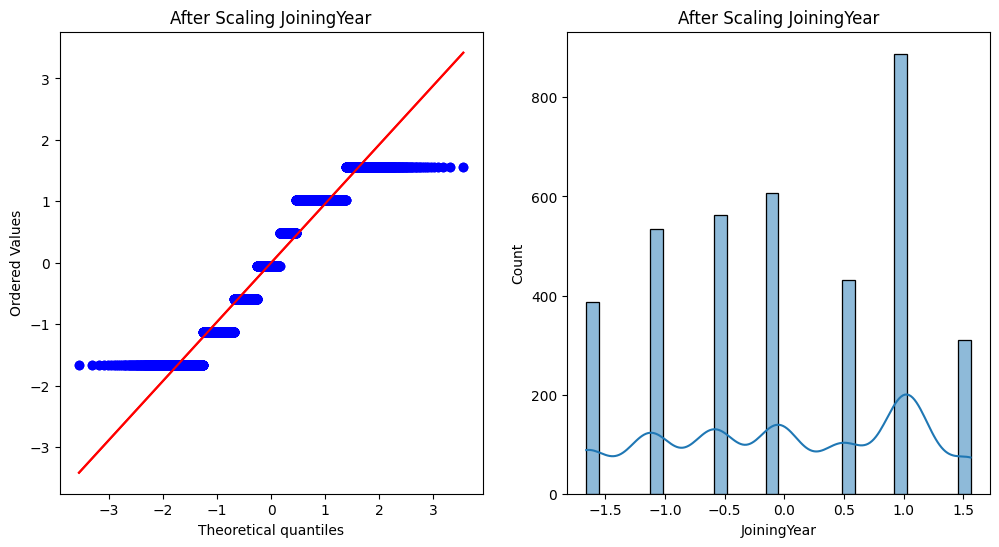

In [64]:
scaler = StandardScaler()
X_train['JoiningYear'] = scaler.fit_transform(X_train[['JoiningYear']])
X_test['JoiningYear'] = scaler.transform(X_test[['JoiningYear']])

plot_qq_hist(employee_data, 'JoiningYear', title='Before Scaling JoiningYear')
plot_qq_hist(X_train, 'JoiningYear', title='After Scaling JoiningYear')

In [65]:
categorical_features = ['City', 'Gender', 'EverBenched']
ordinal_features = ['Education', 'PaymentTier']
descrete_features = ['Age']

education_order = ['High School', 'Bachelors', 'Masters', 'PHD']
payment_tier_order = [1, 2, 3]

categorical_transformer = OneHotEncoder(drop='first')
ordinal_transformer = OrdinalEncoder(categories=[education_order, payment_tier_order])
descrete_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('des', descrete_transformer, descrete_features)
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape

((3722, 9), (931, 9))

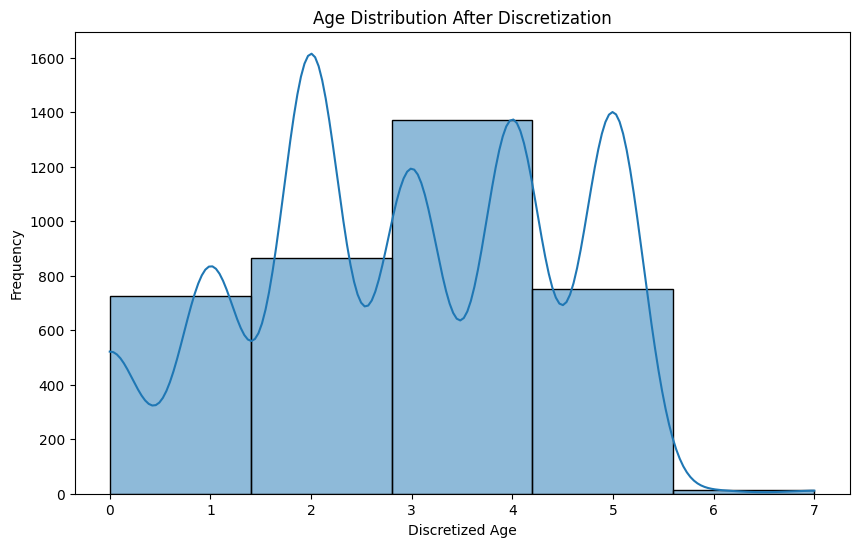

In [66]:
discretized_age_train = X_train[:, -1]
plt.figure(figsize=(10, 6))
sns.histplot(discretized_age_train, kde=True, bins=5)
plt.title('Age Distribution After Discretization')
plt.xlabel('Discretized Age')
plt.ylabel('Frequency')
plt.show()

Class distribution in training set:
LeaveOrNot
0    2442
1    1280
Name: count, dtype: int64


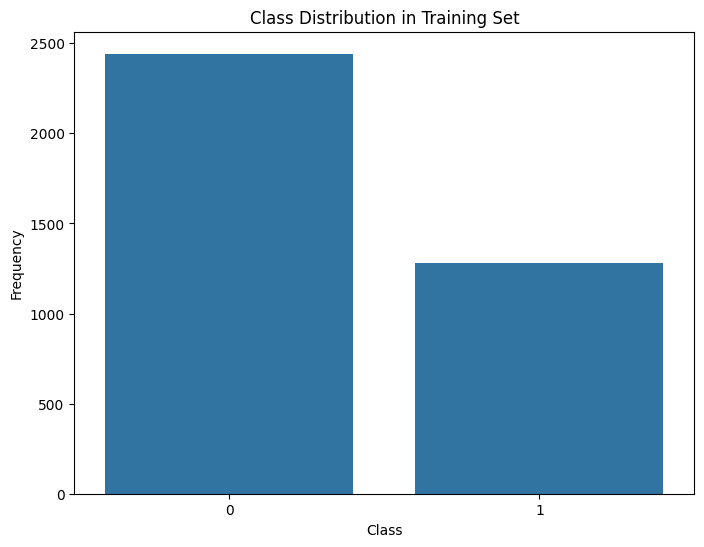

Class imbalance detected. Applying SMOTE...
Resampled class distribution:
LeaveOrNot
0    2442
1    2442
Name: count, dtype: int64


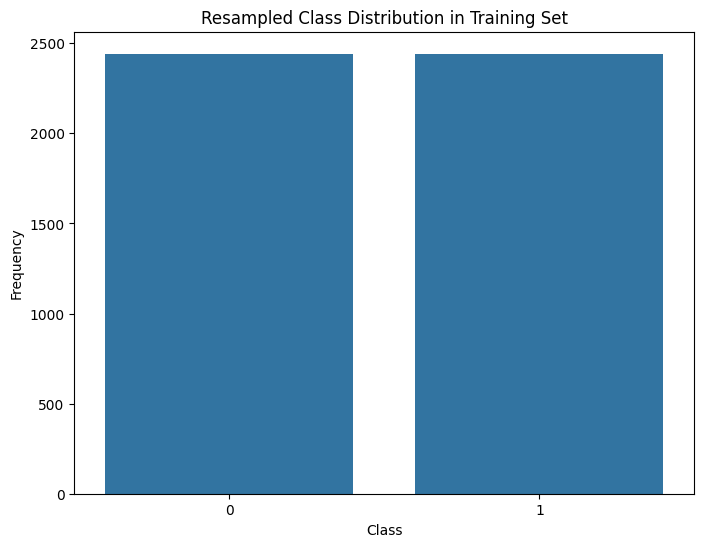

In [67]:
class_counts = y_train.value_counts()
print("Class distribution in training set:")
print(class_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

if class_counts.min() / class_counts.max() < 0.6:
	print("Class imbalance detected. Applying SMOTE...")
	smote = SMOTE(random_state=42)
	X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
	print("Resampled class distribution:")
	print(y_train_resampled.value_counts())

	# Plot resampled class distribution
	plt.figure(figsize=(8, 6))
	sns.barplot(x=y_train_resampled.value_counts().index, y=y_train_resampled.value_counts().values)
	plt.title('Resampled Class Distribution in Training Set')
	plt.xlabel('Class')
	plt.ylabel('Frequency')
	plt.show()
else:
	X_train_resampled, y_train_resampled = X_train, y_train

Handling Class Imbalance with SMOTE
In the preprocessing phase, we identified class imbalance in the training dataset, where the majority class significantly outnumbered the minority class. To address this issue, we applied SMOTE (Synthetic Minority Over-sampling Technique), which generates synthetic samples for the minority class. This technique helps to balance the dataset and prevent the model from becoming biased toward the majority class. By using SMOTE, we aim to improve the model's ability to predict the minority class and achieve better classification performance.

(b) MLP for Employee Attrition Prediction Model
This model predicts employee attrition using a Multi-Layer Perceptron (MLP) built with Keras and TensorFlow. The goal is to predict whether an employee is likely to leave the company based on features such as age, experience, education, and payment tier.

Model Architecture
Input Layer: Accepts input features and passes them to the first hidden layer.
Hidden Layers: Fully connected layers with ReLU activation to learn data patterns.
Batch Normalization: Applied after each hidden layer to stabilize activations and aid convergence.
Dropout Layers: Dropout of 0.4 to prevent overfitting.
Output Layer: Uses sigmoid activation to predict a binary outcome (whether the employee will leave or stay).
Model Parameters
Weight Initialization: Experiments with methods like He Normal, Glorot Uniform, and He Uniform to initialize the weights.
Activation Functions: Uses ReLU, Tanh, and Sigmoid functions for hidden layers.
Optimizers: The model is trained with Adam and RMSprop optimizers.
Learning Rate: Various learning rates (0.001, 0.01, 0.0001) are tested to find the optimal training rate.
Batch Size: The batch size is varied (32, 64, 128) to optimize training.
Training Process
Early Stopping: Training halts if the validation loss does not improve for 10 epochs.
Learning Rate Scheduler: Reduces the learning rate if validation loss does not improve for 5 epochs.
Evaluation
Performance Metrics:

Accuracy: Measures the proportion of correct predictions.
Precision, Recall, and F1-Score: Detailed evaluation of the model's performance, especially for the minority class.
Confusion Matrix: Helps in evaluating classification errors.
Visualizations:

The confusion matrix is visualized as a heatmap to better understand the model's performance.
Hyperparameter Tuning
Different configurations are tested, including:

Weight Initialization: HeNormal, GlorotUniform, RandomNormal, HeUniform.
Activation Functions: ReLU, Tanh, Sigmoid.
Optimizers: Adam, RMSprop.
Learning Rates: 0.001, 0.01, 0.0001.
Batch Sizes: 32, 64, 128.

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal, GlorotUniform, RandomNormal, HeUniform
from tensorflow.keras.activations import relu, tanh, sigmoid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class EmployeeAttritionModel:
    def __init__(
            self, input_dim,
            layers=[128, 64, 32],
            dropout_rate=0.4,
            learning_rate=0.001,
            initializer='he_normal',
            activation='relu',
            optimizer_type='adam'
        ):
        self.model = Sequential()
        self.input_dim = input_dim
        self.layers = layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.initializer = initializer
        self.activation = activation
        self.optimizer_type = optimizer_type
        self._build_model()

    def _build_model(self):
        # Input layer with weight initializer and activation function
        self.model.add(Dense(self.layers[0], input_dim=self.input_dim, activation=self.activation,
                             kernel_initializer=self.initializer))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(self.dropout_rate))

        # Hidden layers
        for units in self.layers[1:]:
            self.model.add(Dense(units, activation=self.activation, kernel_initializer=self.initializer))
            self.model.add(BatchNormalization())
            self.model.add(Dropout(self.dropout_rate))

        # Output layer
        self.model.add(Dense(1, activation='sigmoid', kernel_initializer=self.initializer))

        # Compile the model with the chosen optimizer
        optimizer = Adam(learning_rate=self.learning_rate) if self.optimizer_type == 'adam' else RMSprop(learning_rate=self.learning_rate)

        self.model.compile(optimizer=optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs=125, batch_size=32, patience=10, reduce_lr_patience=5, min_lr=0.0001):
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=reduce_lr_patience, min_lr=min_lr)

        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, reduce_lr])
        return history

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        return loss, accuracy

    def predict(self, X_test, threshold=0.5):
        return (self.model.predict(X_test) > threshold).astype("int32")


Testing config: Initializer=HeNormal, Activation=relu, Optimizer=adam, Learning Rate=0.001, Batch Size=32
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5394 - loss: 0.9005 - val_accuracy: 0.7089 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - loss: 0.7131 - val_accuracy: 0.7444 - val_loss: 0.5607 - learning_rate: 0.0010
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6318 - loss: 0.6743 - val_accuracy: 0.7476 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6441 - loss: 0.6468 - val_accuracy: 0.7476 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6840 - loss: 0.6130 - val_accuracy: 0.7723 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6886 - loss: 0.6057 - val_accuracy: 0.7755 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6999 - loss: 0.5859 - val_

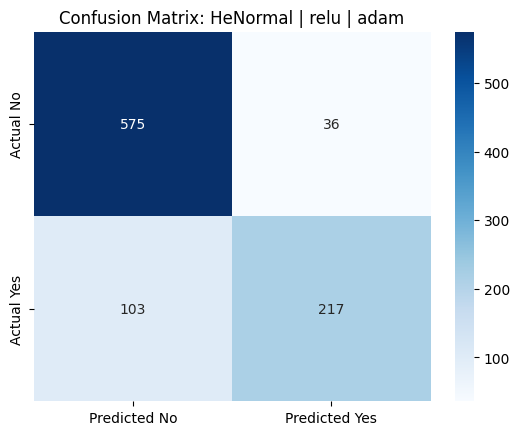


Testing config: Initializer=GlorotUniform, Activation=tanh, Optimizer=adam, Learning Rate=0.01, Batch Size=64
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5995 - loss: 0.7384 - val_accuracy: 0.7207 - val_loss: 0.5646 - learning_rate: 0.0100
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 0.5989 - val_accuracy: 0.7218 - val_loss: 0.5334 - learning_rate: 0.0100
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7100 - loss: 0.5646 - val_accuracy: 0.7487 - val_loss: 0.5207 - learning_rate: 0.0100
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7314 - loss: 0.5394 - val_accuracy: 0.7315 - val_loss: 0.5334 - learning_rate: 0.0100
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394 - loss: 0.5218 - val_accuracy: 0.7916 - val_loss: 0.4626 - learning_rate: 0.0100
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7647 - loss: 0.4965 - val_accuracy: 0.7970 - val_loss: 0.4537 - learning_rate: 0.0100
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.4815 - val_accuracy: 0.83

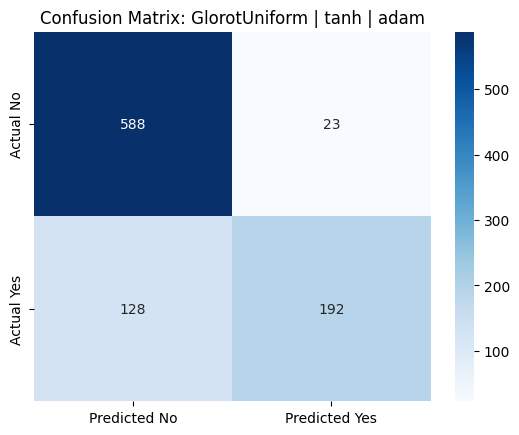


Testing config: Initializer=RandomNormal, Activation=sigmoid, Optimizer=rmsprop, Learning Rate=0.0001, Batch Size=128
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5305 - loss: 0.7065 - val_accuracy: 0.3437 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5968 - loss: 0.6656 - val_accuracy: 0.3437 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6368 - loss: 0.6515 - val_accuracy: 0.3437 - val_loss: 0.6963 - learning_rate: 1.0000e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6612 - loss: 0.6370 - val_accuracy: 0.3437 - val_loss: 0.6950 - learning_rate: 1.0000e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6527 - loss: 0.6341 - val_accuracy: 0.4361 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6507 - loss: 0.6474 - val_accuracy: 0.6412 - val_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6536 - loss: 0.6

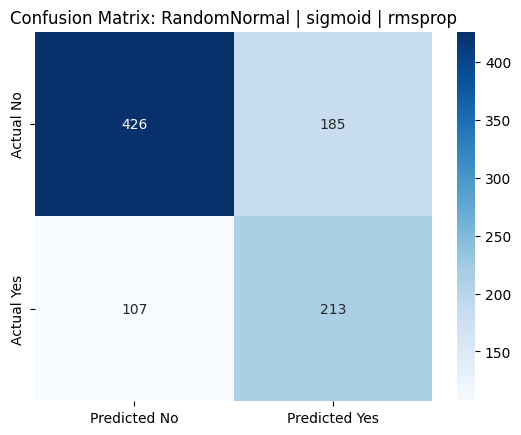


Testing config: Initializer=HeUniform, Activation=relu, Optimizer=adam, Learning Rate=0.001, Batch Size=32
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5373 - loss: 0.9458 - val_accuracy: 0.6466 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6183 - loss: 0.7315 - val_accuracy: 0.6896 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6311 - loss: 0.6780 - val_accuracy: 0.7035 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6400 - loss: 0.6465 - val_accuracy: 0.7100 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6569 - loss: 0.6262 - val_accuracy: 0.7218 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6876 - loss: 0.6005 - val_accuracy: 0.7454 - val_loss: 0.5286 - learning_rate: 0.0010
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7019 - loss: 0.5800 - val_

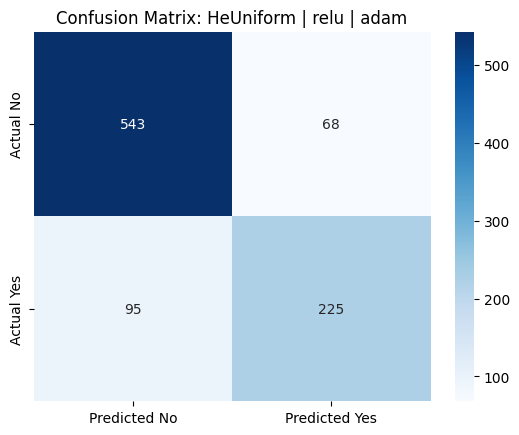


Testing config: Initializer=HeNormal, Activation=tanh, Optimizer=rmsprop, Learning Rate=0.005, Batch Size=64
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5966 - loss: 0.7730 - val_accuracy: 0.7089 - val_loss: 0.5735 - learning_rate: 0.0050
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6677 - loss: 0.6255 - val_accuracy: 0.7272 - val_loss: 0.5527 - learning_rate: 0.0050
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7051 - loss: 0.5840 - val_accuracy: 0.7540 - val_loss: 0.5309 - learning_rate: 0.0050
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7194 - loss: 0.5666 - val_accuracy: 0.7626 - val_loss: 0.4951 - learning_rate: 0.0050
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.5555 - val_accuracy: 0.7476 - val_loss: 0.5252 - learning_rate: 0.0050
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7329 - loss: 0.5362 - val_accuracy: 0.7701 - val_loss: 0.4732 - learning_rate: 0.0050
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7497 - loss: 0.5084 - val_accuracy: 0.81

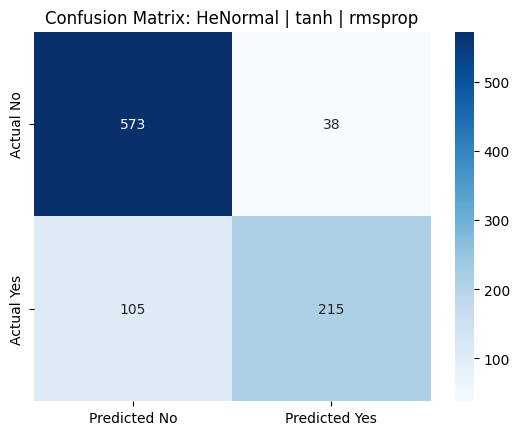


Model Evaluation Summary:


,initializer,activation,optimizer,learning_rate,batch_size,accuracy,loss,classification_report,confusion_matrix
0,HeNormal,relu,adam,0.0010,32,0.850698,0.378686,"{'0': {'precision': 0.8480825958702065, 'recal...","[[575, 36], [103, 217]]"
1,GlorotUniform,tanh,adam,0.0100,64,0.837809,0.401117,"{'0': {'precision': 0.8212290502793296, 'recal...","[[588, 23], [128, 192]]"
2,RandomNormal,sigmoid,rmsprop,0.0001,128,0.686359,0.605941,"{'0': {'precision': 0.799249530956848, 'recall...","[[426, 185], [107, 213]]"
3,HeUniform,relu,adam,0.0010,32,0.824919,0.419720,"{'0': {'precision': 0.8510971786833855, 'recal...","[[543, 68], [95, 225]]"
4,HeNormal,tanh,rmsprop,0.0050,64,0.846402,0.392537,"{'0': {'precision': 0.8451327433628318, 'recal...","[[573, 38], [105, 215]]"


In [69]:
configs = [
    {"initializer": HeNormal(), "activation": "relu", "optimizer_type": "adam", "learning_rate": 0.001, "batch_size": 32},
    {"initializer": GlorotUniform(), "activation": "tanh", "optimizer_type": "adam", "learning_rate": 0.01, "batch_size": 64},
    {"initializer": RandomNormal(), "activation": "sigmoid", "optimizer_type": "rmsprop", "learning_rate": 0.0001, "batch_size": 128},
    {"initializer": HeUniform(), "activation": "relu", "optimizer_type": "adam", "learning_rate": 0.001, "batch_size": 32},
    {"initializer": HeNormal(), "activation": "tanh", "optimizer_type": "rmsprop", "learning_rate": 0.005, "batch_size": 64}
]

overall_report = []

for config in configs:
    print(f"\nTesting config: Initializer={config['initializer'].__class__.__name__}, Activation={config['activation']}, Optimizer={config['optimizer_type']}, Learning Rate={config['learning_rate']}, Batch Size={config['batch_size']}")
    attrition_model = EmployeeAttritionModel(input_dim=X_train_resampled.shape[1],
                                             initializer=config["initializer"],
                                             activation=config["activation"],
                                             optimizer_type=config["optimizer_type"],
                                             learning_rate=config["learning_rate"])

    history = attrition_model.train(X_train_resampled, y_train_resampled, X_test, y_test, epochs=100, batch_size=config["batch_size"])
    loss, accuracy = attrition_model.evaluate(X_test, y_test)

    y_pred = attrition_model.predict(X_test)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    confusion_mat = confusion_matrix(y_test, y_pred)

    overall_report.append({
        "initializer": config["initializer"].__class__.__name__,
        "activation": config["activation"],
        "optimizer": config["optimizer_type"],
        "learning_rate": config["learning_rate"],
        "batch_size": config["batch_size"],
        "accuracy": accuracy,
        "loss": loss,
        "classification_report": class_report,
        "confusion_matrix": confusion_mat
    })

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print("Classification Report:")
    print(class_report)

    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
    plt.title(f"Confusion Matrix: {config['initializer'].__class__.__name__} | {config['activation']} | {config['optimizer_type']}")
    plt.show()

overall_results_df = pd.DataFrame(overall_report)
overall_results_df.to_csv("model_performance_summary.csv", index=False)

print("\nModel Evaluation Summary:")
overall_results_df

(d) Model Evaluation at Different Thresholds
In this section, we assess the performance of the employee attrition prediction model at various decision thresholds. The purpose is to understand how changes in the threshold for classifying an employee as likely to leave affect the model's performance metrics.

Thresholds Evaluated
0.1
0.3
0.5
0.7
0.9
Performance Metrics
For each threshold, the following metrics are evaluated:

Accuracy: The percentage of correct predictions made by the model.
Precision: The ratio of correctly predicted positive cases to the total predicted positives.
Recall: The ratio of correctly predicted positive cases to the total actual positives.
F1-Score: The harmonic mean of precision and recall, offering a balance between the two metrics.
Confusion Matrix: A table that shows the number of true positives, true negatives, false positives, and false negatives to provide insights into classification errors.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold: 0.1
Test Accuracy: 0.3437
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       611
           1       0.34      1.00      0.51       320

    accuracy                           0.34       931
   macro avg       0.17      0.50      0.26       931
weighted avg       0.12      0.34      0.18       931



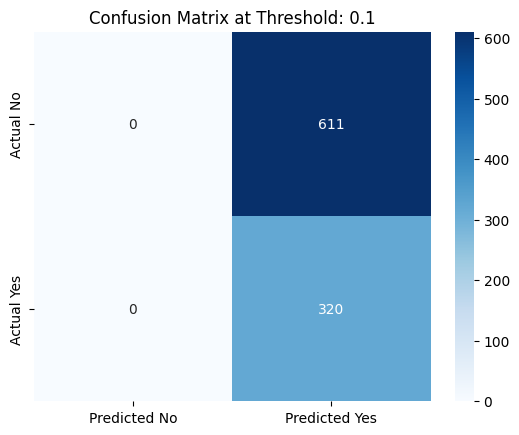

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold: 0.30000000000000004
Test Accuracy: 0.8153
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       611
           1       0.71      0.78      0.74       320

    accuracy                           0.82       931
   macro avg       0.79      0.81      0.80       931
weighted avg       0.82      0.82      0.82       931



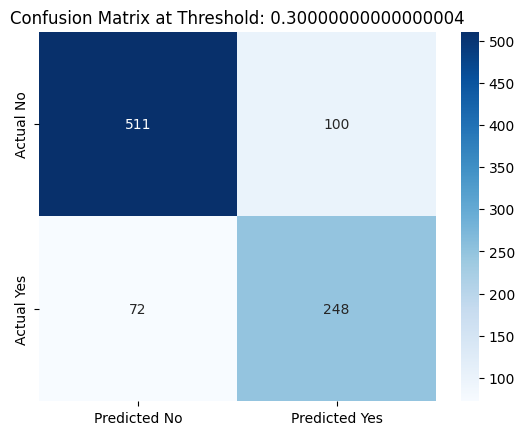

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold: 0.5
Test Accuracy: 0.8464
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       611
           1       0.85      0.67      0.75       320

    accuracy                           0.85       931
   macro avg       0.85      0.80      0.82       931
weighted avg       0.85      0.85      0.84       931



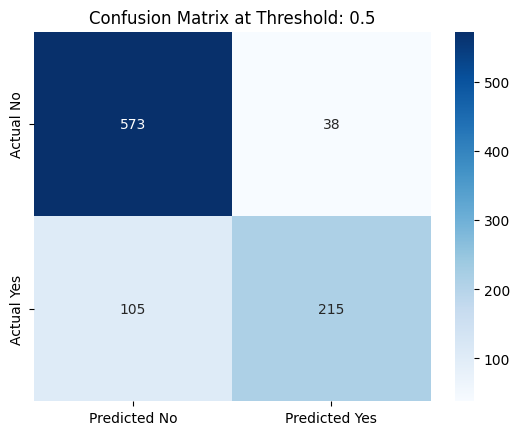

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold: 0.7000000000000001
Test Accuracy: 0.8346
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.88       611
           1       0.90      0.58      0.71       320

    accuracy                           0.83       931
   macro avg       0.86      0.77      0.80       931
weighted avg       0.85      0.83      0.82       931



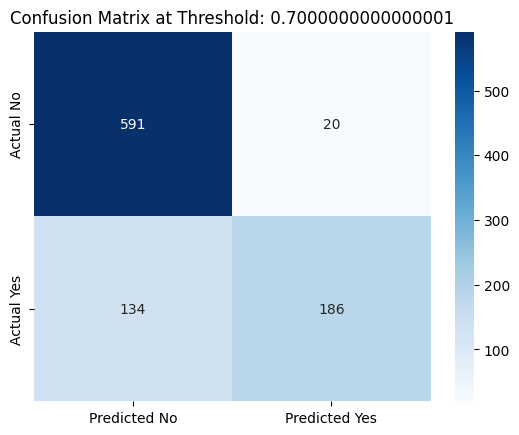

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold: 0.9
Test Accuracy: 0.8174
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       611
           1       0.95      0.49      0.65       320

    accuracy                           0.82       931
   macro avg       0.87      0.74      0.76       931
weighted avg       0.84      0.82      0.80       931



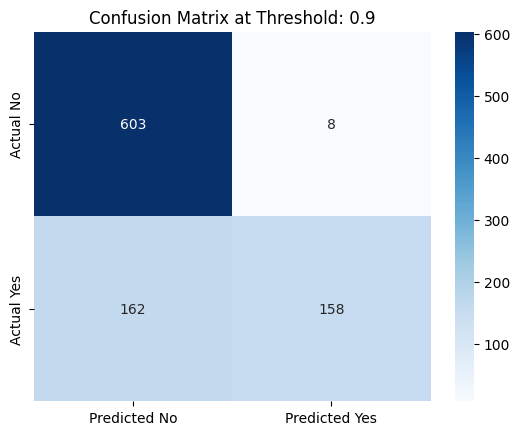


Threshold Evaluation Summary:


,threshold,accuracy,classification_report,confusion_matrix
0,0.1,0.343716,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...","[[0, 611], [0, 320]]"
1,0.3,0.815252,"{'0': {'precision': 0.8765008576329331, 'recal...","[[511, 100], [72, 248]]"
2,0.5,0.846402,"{'0': {'precision': 0.8451327433628318, 'recal...","[[573, 38], [105, 215]]"
3,0.7,0.834586,"{'0': {'precision': 0.8151724137931035, 'recal...","[[591, 20], [134, 186]]"
4,0.9,0.817401,"{'0': {'precision': 0.788235294117647, 'recall...","[[603, 8], [162, 158]]"


In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model_at_thresholds(model, X_test, y_test, thresholds=np.linspace(0.1, 0.9, 5)):
    # For storing results
    threshold_results = []

    # Evaluate the model for each threshold
    for threshold in thresholds:
        y_pred_threshold = (model.predict(X_test) > threshold).astype("int32")
        accuracy = accuracy_score(y_test, y_pred_threshold)
        class_report = classification_report(y_test, y_pred_threshold, output_dict=True, zero_division=0)
        confusion_mat = confusion_matrix(y_test, y_pred_threshold)

        # Save the results for each threshold
        threshold_results.append({
            "threshold": threshold,
            "accuracy": accuracy,
            "classification_report": class_report,
            "confusion_matrix": confusion_mat
        })

        # Display classification report
        print(f"Threshold: {threshold}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_threshold, zero_division=0))

        # Confusion Matrix Visualization
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
        plt.title(f"Confusion Matrix at Threshold: {threshold}")
        plt.show()

    # Save threshold results as a CSV or detailed summary
    threshold_results_df = pd.DataFrame(threshold_results)
    threshold_results_df.to_csv("threshold_performance_summary.csv", index=False)

    # Display summary as a table
    print("\nThreshold Evaluation Summary:")
    return threshold_results_df

# Example usage:
threshold_results_df = evaluate_model_at_thresholds(attrition_model.model, X_test, y_test)
threshold_results_df